In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding "  # this disables constant folding
#     # "--xla_cpu_use_thunk_runtime=false "
# )
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [3]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *
from desc.io import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *
from desc.particles import *
from diffrax import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.16.0+411.g6e1e51890.
Using JAX backend: jax version=0.7.2, jaxlib version=0.7.2, dtype=float64.
Using device: NVIDIA A100-PCIE-40GB (id=0), with 40.00 GB available memory.


In [4]:
from desc.objectives.objective_funs import _Objective
from desc.compute.utils import _compute as compute_fun


class ForceBalanceDeflated(_Objective):
    """Radial and helical MHD force balance.

    Given force densities:

    Fᵨ = √g (J^θ B^ζ - J^ζ B^θ) - ∇ p

    Fₕₑₗᵢ √g J^ρ

    and helical basis vector:

    𝐞ʰᵉˡⁱ = B^ζ ∇ θ - B^θ ∇ ζ

    Minimizes the magnitude of the forces:

    fᵨ = Fᵨ ||∇ ρ|| dV  (N)

    fₕₑₗᵢ = Fₕₑₗᵢ ||𝐞ʰᵉˡⁱ|| dV  (N)

    Parameters
    ----------
    eq : Equilibrium
        Equilibrium that will be optimized to satisfy the Objective.
    eqs: list of Equilibrium
        list of Equilibrium objects to use in deflation operator.
    sigma: float, optional
        sigma term in deflation operator
    power: float, optional
        power parameter in deflation operator.
    grid : Grid, optional
        Collocation grid containing the nodes to evaluate at.
        Defaults to ``ConcentricGrid(eq.L_grid, eq.M_grid, eq.N_grid)``
    """

    __doc__ = __doc__.rstrip() + collect_docs(
        target_default="``target=0``.", bounds_default="``target=0``."
    )
    _static_attrs = _Objective._static_attrs + ["_params_to_deflate_with"]

    _equilibrium = True
    _coordinates = "rtz"
    _units = "(N)"
    _print_value_fmt = "Force error: "

    def __init__(
        self,
        eq,
        eqs,
        sigma=0.05,
        power=2,
        target=None,
        bounds=None,
        weight=1,
        normalize=True,
        normalize_target=True,
        loss_function=None,
        deriv_mode="auto",
        grid=None,
        name="force",
        jac_chunk_size=None,
    ):
        if target is None and bounds is None:
            target = 0
        self._grid = grid
        self._eqs = eqs
        self._sigma = sigma
        self._power = power
        super().__init__(
            things=eq,
            target=target,
            bounds=bounds,
            weight=weight,
            normalize=normalize,
            normalize_target=normalize_target,
            loss_function=loss_function,
            deriv_mode=deriv_mode,
            name=name,
            jac_chunk_size=jac_chunk_size,
        )

    def build(self, use_jit=True, verbose=1):
        """Build constant arrays.

        Parameters
        ----------
        use_jit : bool, optional
            Whether to just-in-time compile the objective and derivatives.
        verbose : int, optional
            Level of output.

        """
        eq = self.things[0]
        if self._grid is None:
            grid = ConcentricGrid(
                L=eq.L_grid,
                M=eq.M_grid,
                N=eq.N_grid,
                NFP=eq.NFP,
                sym=eq.sym,
                axis=False,
            )
        else:
            grid = self._grid

        self._dim_f = 2 * grid.num_nodes
        self._data_keys = [
            "F_rho",
            "|grad(rho)|",
            "sqrt(g)",
            "F_helical",
            "|e^helical*sqrt(g)|",
        ]

        timer = Timer()
        if verbose > 0:
            print("Precomputing transforms")
        timer.start("Precomputing transforms")

        profiles = get_profiles(self._data_keys, obj=eq, grid=grid)
        transforms = get_transforms(self._data_keys, obj=eq, grid=grid)

        self._constants = {
            "transforms": transforms,
            "profiles": profiles,
        }
        print("Building R to Rb matrix")
        Robj = BoundaryRSelfConsistency(eq)
        Robj.build()
        self.Ar = Robj._A

        print("Building Z to Zb matrix")
        Zobj = BoundaryZSelfConsistency(eq)
        Zobj.build()
        self.Az = Zobj._A

        timer.stop("Precomputing transforms")
        if verbose > 1:
            timer.disp("Precomputing transforms")

        if self._normalize:
            scales = compute_scaling_factors(eq)
            self._normalization = scales["f"]

        super().build(use_jit=use_jit, verbose=verbose)

    def compute(self, params, constants=None):
        """Compute MHD force balance errors.

        Parameters
        ----------
        params : dict
            Dictionary of equilibrium degrees of freedom, eg Equilibrium.params_dict
        constants : dict
            Dictionary of constant data, eg transforms, profiles etc. Defaults to
            self.constants

        Returns
        -------
        f : ndarray
            MHD force balance error at each node (N).

        """
        if constants is None:
            constants = self.constants
        data = compute_fun(
            "desc.equilibrium.equilibrium.Equilibrium",
            self._data_keys,
            params=params,
            transforms=constants["transforms"],
            profiles=constants["profiles"],
        )
        fr = data["F_rho"] * data["|grad(rho)|"] * data["sqrt(g)"]
        fb = data["F_helical"] * data["|e^helical*sqrt(g)|"]
        keys = ["R_lmn", "Z_lmn"]
        As = [self.Ar, self.Az]
        diffs = [
            jnp.concatenate([A@(params[key] - eq.params_dict[key]) for A, key in zip(As, keys)])
            for eq in self._eqs
        ]
        diffs = jnp.vstack(diffs)
        deflation_parameter = jnp.prod(
            1 / jnp.linalg.norm(diffs, axis=1) ** self._power + self._sigma
        )
        return jnp.concatenate([fr, fb]) * deflation_parameter

In [5]:
def set_poincare_equilibrium(eq):
    eq_poincare = Equilibrium(
        xsection=eq.get_surface_at(zeta=0),
        pressure=eq.pressure,
        iota=eq.iota,
        Psi=eq.Psi,  # flux (in Webers) within the last closed flux surface
        NFP=eq.NFP,  # number of field periods
        L=eq.L,  # radial spectral resolution
        M=eq.M,  # poloidal spectral resolution
        N=eq.N,  # toroidal spectral resolution
        L_grid=eq.L_grid,  # real space radial resolution, slightly oversampled
        M_grid=eq.M_grid,  # real space poloidal resolution, slightly oversampled
        N_grid=eq.N_grid,  # real space toroidal resolution
        sym=eq.sym,  # explicitly enforce stellarator symmetry
        spectral_indexing=eq._spectral_indexing,
    )

    eq_poincare.change_resolution(eq.L, eq.M, eq.N)
    eq_poincare.axis = eq_poincare.get_axis()
    eq_poincare.surface = eq_poincare.get_surface_at(rho=1)
    return eq_poincare

In [7]:
name = "precise_QA"
LMN = 12
try:
    eq0h = desc.io.load(f"{name}_LMN_{LMN}.h5")
except:
    eq0 = get(name)
    eq0h = eq0.copy()
    eq0h.change_resolution(L=LMN, M=LMN, L_grid=LMN*2, M_grid=LMN*2, N=LMN, N_grid=LMN*2)
    eq0h.solve(
        maxiter=500,
        ftol=1e-3,
        xtol=0,
        gtol=0,
        verbose=3,
        x_scale="ess",
    );
    eq0h.xsection = eq0h.get_surface_at(zeta=0)
    eq0h.save(f"{name}_LMN_12.h5")

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 2.70 sec
Timer: Objective build = 3.77 sec
Building objective: fixed LCFS R
Building objective: fixed LCFS Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency lcfs R
Building objective: self_consistency lcfs Z
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Timer: Objective build = 1.52 sec
Timer: LinearConstraintProjection build = 7.92 sec
Number of parameters: 2784
Number of objectives: 16562
Timer: Initializing the optimization = 13.7 sec

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 2501
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust Region Method    

In [ ]:
try:
    eqp0 = desc.io.load(f"{name}_LMN_{LMN}_poincare.h5")
except:
    eqp0 = eq0h.copy()
    constraints = get_fixed_xsection_constraints(eq=eqp0, fix_lambda=True)
    objective = ObjectiveFunction(ForceBalance(eqp0))
    
    eqp0.solve(
        verbose=3,
        objective=objective,
        constraints=constraints,
        maxiter=800,
        ftol=1e-3,
        x_scale="ess",
    )
    
    eqp0.surface = eqp0.get_surface_at(rho=1)
    eqp0.save(f"{name}_LMN_{LMN}_poincare.h5")

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 141 ms
Timer: Objective build = 255 ms
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed cross-section λ
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 626 ms
Timer: LinearConstraintProjection build = 5.83 sec
Number of parameters: 3276
Number of objectives: 16562
Timer: Initializing the optimization = 7.21 sec

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 4001

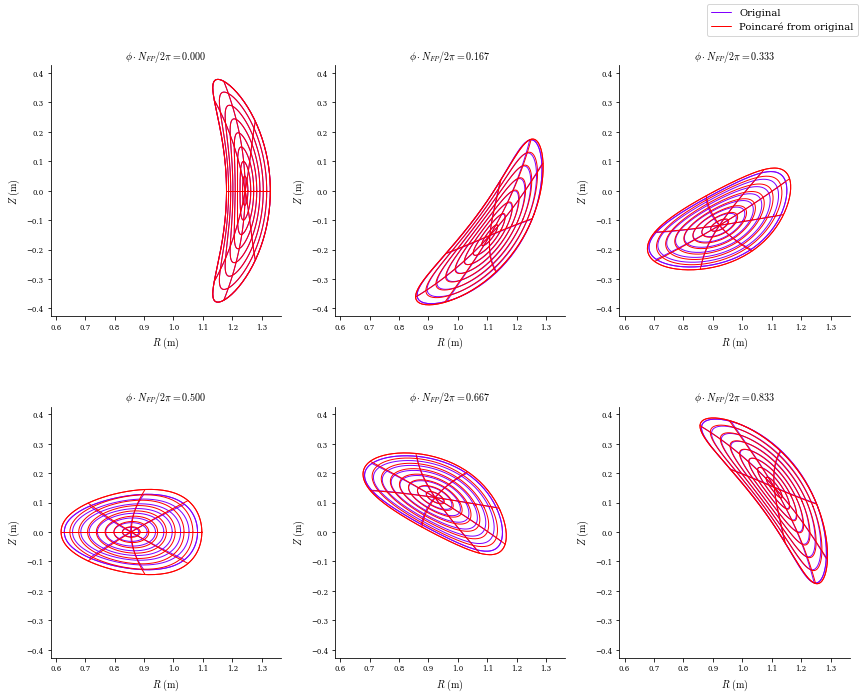

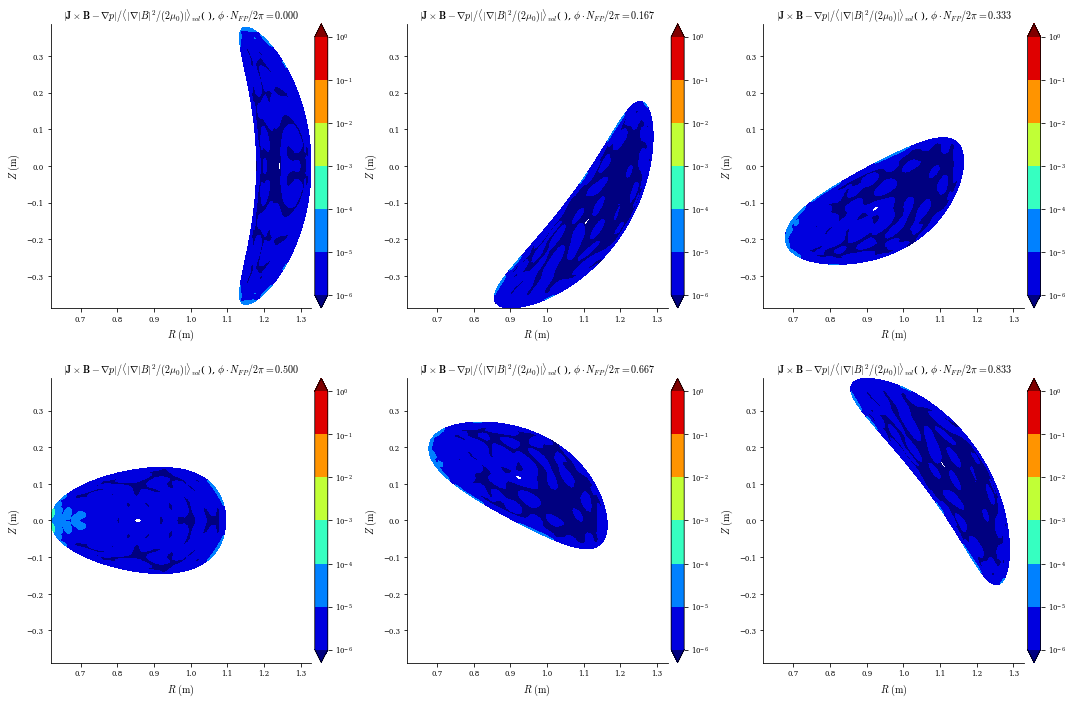

In [9]:
plot_comparison([eq0h, eqp0], labels=["Original", "Poincaré from original"]);
plot_section(eqp0, "|F|_normalized", log=True);

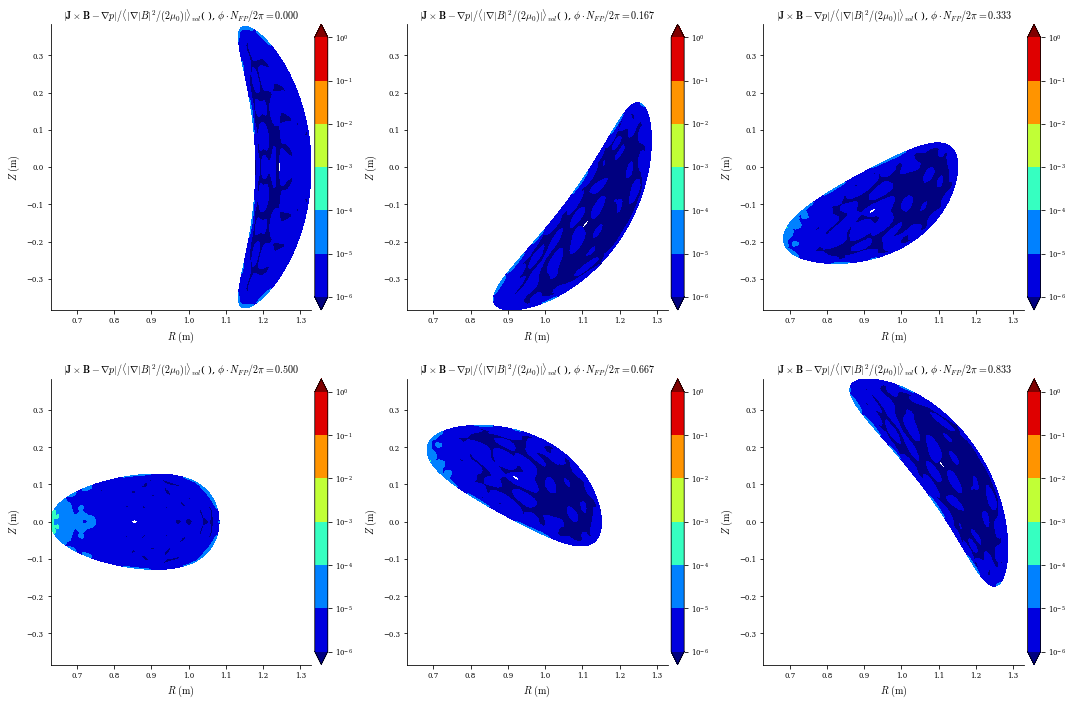

In [10]:
plot_section(eq0h, "|F|_normalized", log=True);

In [8]:
try:
    eqp0_as = desc.io.load(f"{name}_LMN_{LMN}_poincare_as.h5")
except:
    eqp0_as = set_poincare_equilibrium(eq0h)
    constraints = get_fixed_xsection_constraints(eq=eqp0_as, fix_lambda=True)
    objective = ObjectiveFunction(ForceBalance(eqp0_as))
    
    eqp0_as.solve(
        verbose=3,
        objective=objective,
        constraints=constraints,
        maxiter=1000,
        ftol=1e-3,
        x_scale="ess",
    )
    
    eqp0_as.surface = eqp0_as.get_surface_at(rho=1)
    eqp0_as.save(f"{name}_LMN_{LMN}_poincare_as.h5")

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 139 ms
Timer: Objective build = 255 ms
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed cross-section λ
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 332 ms
Timer: LinearConstraintProjection build = 6.20 sec
Number of parameters: 3276
Number of objectives: 16562
Timer: Initializing the optimization = 7.31 sec

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 5001

NameError: name 'LMN' is not defined

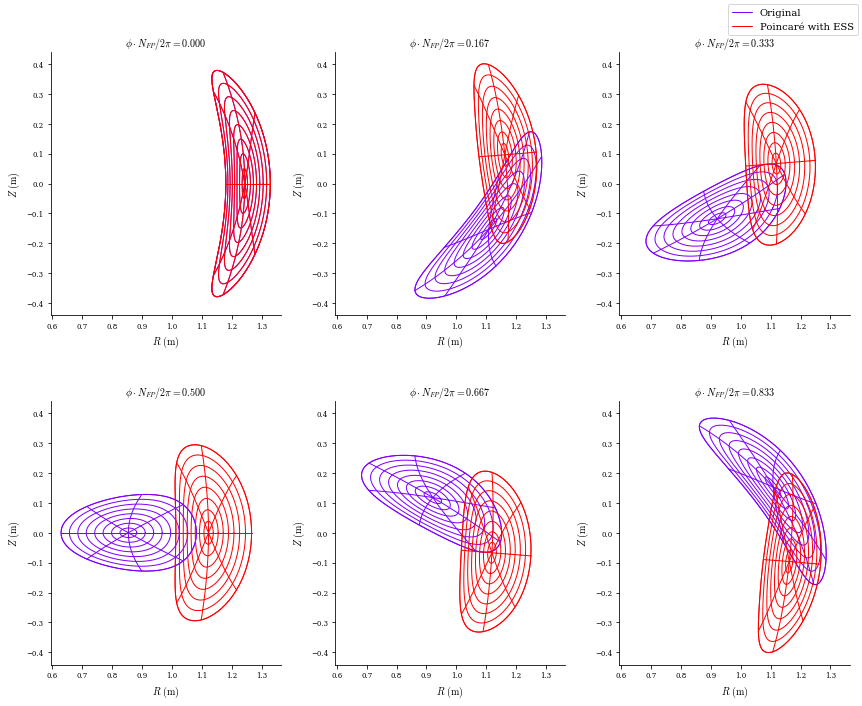

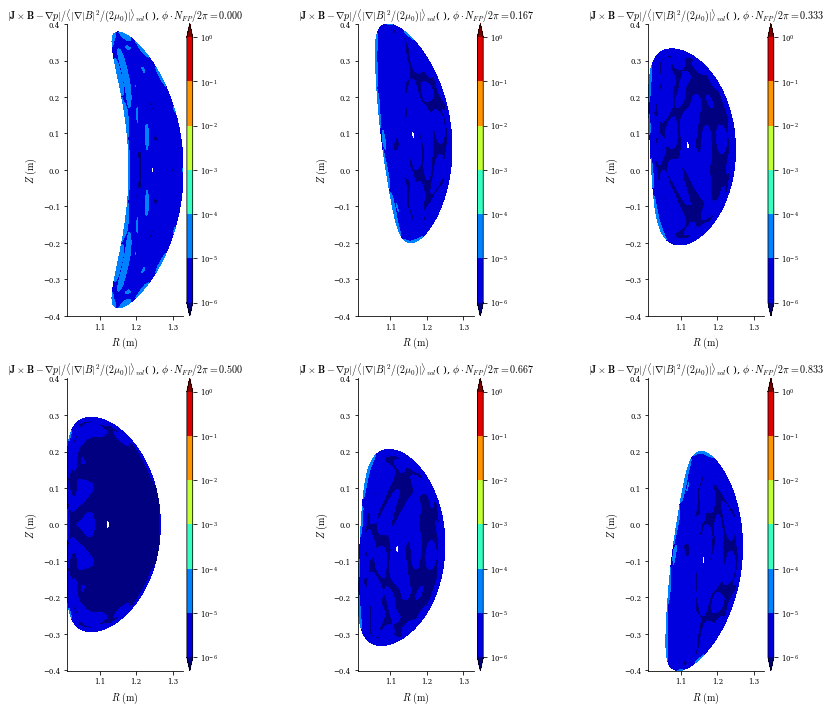

In [11]:
plot_comparison(
    [eq0h, eqp0_as], labels=["Original", "Poincaré with ESS"]
)
plot_section(eqp0_as, "|F|_normalized", log=True);

In [12]:
dont_goto = [eqp0_as]

In [13]:
try:
    eqd1 = desc.io.load(f"{name}_LMN_{LMN}_poincare_as_def1.h5")
except:
    eqd1 = set_poincare_equilibrium(eq0h)
    constraints = get_fixed_xsection_constraints(eq=eqd1, fix_lambda=True)
    objective = ObjectiveFunction(ForceBalanceDeflated(eqd1, eqs=dont_goto, sigma=100, power=2))
    
    eqd1.solve(
        verbose=3,
        objective=objective,
        constraints=constraints,
        maxiter=1000,
        ftol=1e-3,
        x_scale="ess",
    )
    
    eqd1.surface = eqd1.get_surface_at(rho=1)
    eqd1.save(f"{name}_LMN_{LMN}_poincare_as_def1.h5")

Building objective: force
Precomputing transforms
Building R to Rb matrix
Building Z to Zb matrix
Timer: Precomputing transforms = 196 ms
Timer: Objective build = 225 ms
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed cross-section λ
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 214 ms
Timer: LinearConstraintProjection build = 193 ms
Number of parameters: 3276
Number of objectives: 16562
Timer: Initializing the optimization = 656 ms

Starting optimization
Using method: lsq-exact
Solver options:
----------------------------------------------------------

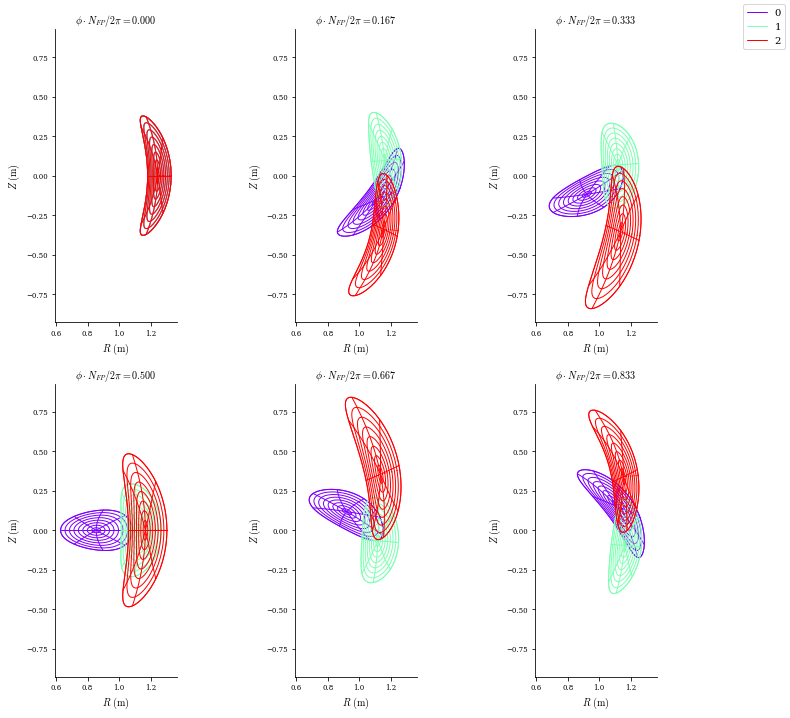

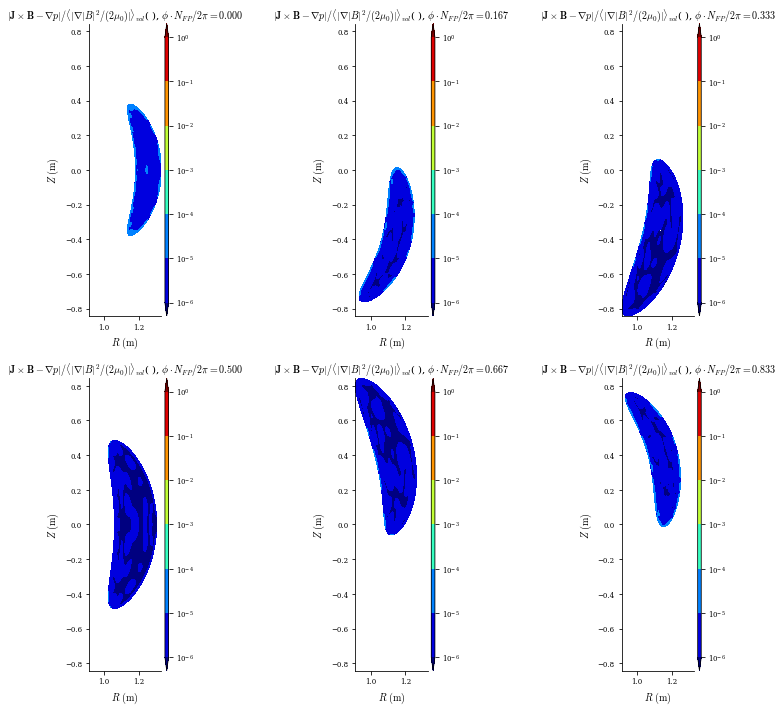

In [15]:
plot_comparison([eq0h, eqp0_as, eqd1])
plot_section(eqd1, "|F|_normalized", log=True);

In [20]:
dont_goto += [eqd1]
try:
    eqd2 = desc.io.load(f"{name}_LMN_{LMN}_poincare_as_def2.h5")
except:
    eqd2 = set_poincare_equilibrium(eq0h)
    constraints = get_fixed_xsection_constraints(eq=eqd2, fix_lambda=True)
    objective = ObjectiveFunction(ForceBalanceDeflated(eqd2, eqs=dont_goto, sigma=50, power=2))
    
    eqd2.solve(
        verbose=3,
        objective=objective,
        constraints=constraints,
        maxiter=800,
        ftol=1e-3,
        x_scale="ess",
    )
    
    eqd2.surface = eqd2.get_surface_at(rho=1)
    eqd2.save(f"{name}_LMN_{LMN}_poincare_as_def2.h5")

Building objective: force
Precomputing transforms
Building R to Rb matrix
Building Z to Zb matrix
Timer: Precomputing transforms = 197 ms
Timer: Objective build = 226 ms
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed cross-section λ
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 231 ms
Timer: LinearConstraintProjection build = 212 ms
Number of parameters: 3276
Number of objectives: 16562
Timer: Initializing the optimization = 693 ms

Starting optimization
Using method: lsq-exact
Solver options:
----------------------------------------------------------

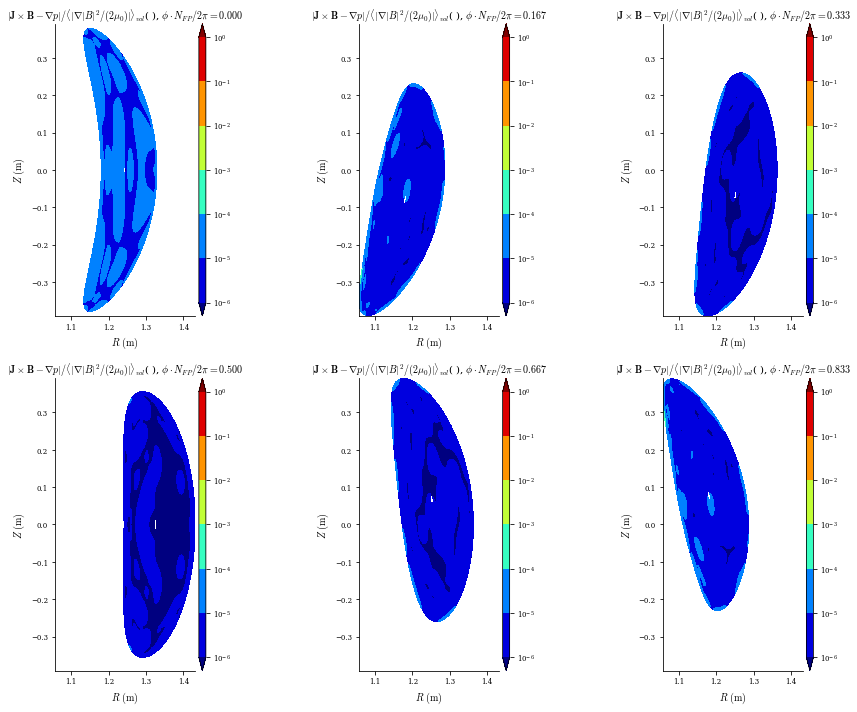

In [21]:
plot_section(eqd2, "|F|_normalized", log=True);

In [22]:
dont_goto += [eqd2]
try:
    eqd3 = desc.io.load(f"{name}_LMN_{LMN}_poincare_as_def3.h5")
except:
    eqd3 = set_poincare_equilibrium(eq0h)
    constraints = get_fixed_xsection_constraints(eq=eqd3, fix_lambda=True)
    objective = ObjectiveFunction(ForceBalanceDeflated(eqd3, eqs=dont_goto, sigma=5, power=2))
    
    eqd3.solve(
        verbose=3,
        objective=objective,
        constraints=constraints,
        maxiter=800,
        ftol=1e-3,
        x_scale="ess",
    )
    
    eqd3.surface = eqd3.get_surface_at(rho=1)
    eqd3.save(f"{name}_LMN_{LMN}_poincare_as_def3.h5")

Building objective: force
Precomputing transforms
Building R to Rb matrix
Building Z to Zb matrix
Timer: Precomputing transforms = 195 ms
Timer: Objective build = 223 ms
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed cross-section λ
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 222 ms
Timer: LinearConstraintProjection build = 194 ms
Number of parameters: 3276
Number of objectives: 16562
Timer: Initializing the optimization = 664 ms

Starting optimization
Using method: lsq-exact
Solver options:
----------------------------------------------------------

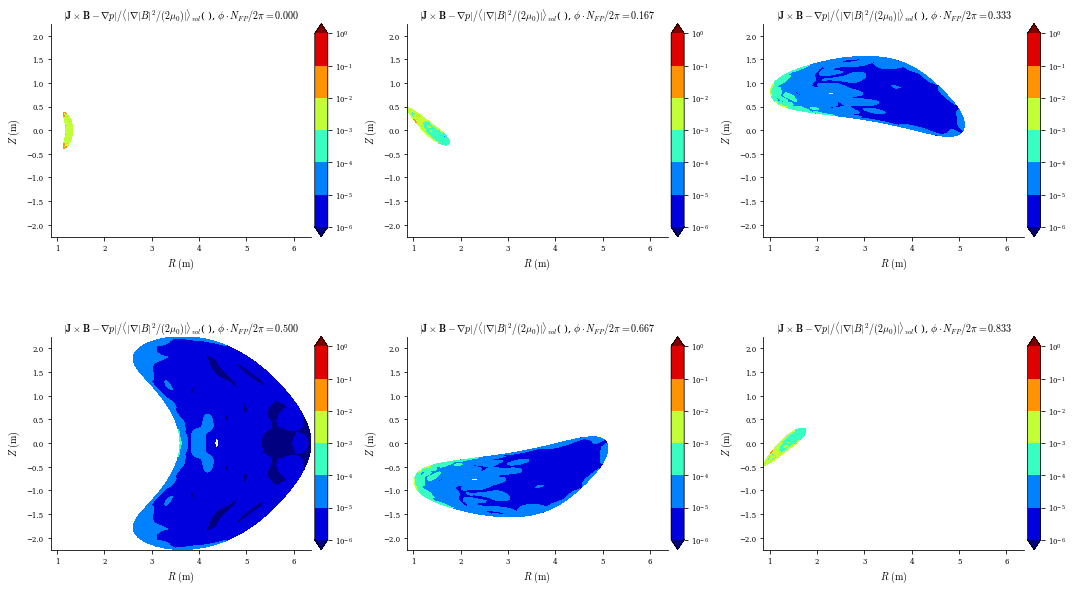

In [23]:
plot_section(eqd3, "|F|_normalized", log=True);